In [1]:
#getting our own spotify data

In [2]:
#importing libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from skimage import io


In [3]:
#Authentication - without user using Spotify's Web API and making a new spotify developer account 
client_credentials_manager = SpotifyClientCredentials(
    client_id="14ab08163a0649be865dc476a3076fd7", client_secret="0ce7157e93604e008992ec4db58d8e70")
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
#Getting user playlist
playlist_link = input("Enter your playlist link: ")
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
offset = 0
track_uris = []
for i in range(100):
    a=[x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI,offset=offset)["items"]]
    for i in a:
        track_uris.append(i)
    offset += 100



In [5]:
print(track_uris)

['spotify:track:2SHnUyZq0zwmvRIl4WY77G', 'spotify:track:6h5PAsRni4IRlxWr6uDPTP', 'spotify:track:0ct6r3EGTcMLPtrXHDvVjc', 'spotify:track:4ywUcVneBL8TNHIq6oJBz2', 'spotify:track:46lFttIf5hnUZMGvjK0Wxo', 'spotify:track:2V65y3PX4DkRhy1djlxd9p', 'spotify:track:4J7CKHCF3mdL4diUsmW8lq', 'spotify:track:1nas007nDbzLwDGwvMdz79', 'spotify:track:2PZFDozX54B0p7uUE3P4K7', 'spotify:track:5M9jOReAKGZ2AttVefFjTY', 'spotify:track:77TT8Xvx637TpzV8kKGkUw', 'spotify:track:4356Typ82hUiFAynbLYbPn', 'spotify:track:5QjJgPU8AJeickx34f7on6', 'spotify:track:5tf1VVWniHgryyumXyJM7w', 'spotify:track:2ISSQPb9LHHiV6ng2NXosL', 'spotify:track:7BKLCZ1jbUBVqRi2FVlTVw', 'spotify:track:6YUTL4dYpB9xZO5qExPf05', 'spotify:track:5vQIaNoKsT4xkG1j2KFBFs', 'spotify:track:591nHHHzZl1NLt9PMKpinM', 'spotify:track:698ItKASDavgwZ3WjaWjtz', 'spotify:track:6vWk151OrbHfKe4D6Z6tdV', 'spotify:track:3EmmCZoqpWOTY1g2GBwJoR', 'spotify:track:2eCjFwE5fwXttf6knCgX91', 'spotify:track:1YDJ2f1JuKzYWZpRYiBYHu', 'spotify:track:1tAutlhI9FwnKn7fVgmd5P',

In [6]:
images = []
for i in range(len(track_uris)):
    track = sp.track(track_uris[i])
    images.append(track["album"]["images"][0]["url"])


KeyboardInterrupt: 

In [ ]:
#Acosticness confidence measure from 0.0 to 1.0 of whether the track is acoustic.
#Danceability measure describes how suitable a track is for dancing.
#duration_ms is the duration of the song track in milliseconds.
#Energy represents a perceptual measure of intensity and activity.
#Instrumentalness predicts whether a track contains vocals or not.
#Loudness of a track in decibels(dB).
#Liveness detects the presence of an audience in the recording.
#Speechiness detects the presence of spoken words in a track
#Time_signature is an estimated overall time signature of a track.
#Key the track is in. Integers map to pitches using standard Pitch Class notation.
#Valence measures from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
#Target value describes the encoded value of 0 and 1. 0 means listener has not saved the song and 1 means listener have saved the song.
#Tempo is in beats per minute(BPM).
#Mode indicates the modality(major or minor) of the song.
#Song_title is the name of the song.
#Artist is the singer of the song.
#URL is the link to the song.



In [ ]:
#making a new csv file with th data and headers as the features of the audio features and also Song Name and Artist Name
song_name = []
artist_name = []
acousticness = []
danceability = []
duration_ms = []
energy = []
instrumentalness = []
loudness = []
liveness=[]
speechiness = []
time_signature = []
key = []
valence = []
tempo = []
mode = []
target = []
url = []
#get track name and artist name
for track_uri in track_uris:
    track = sp.track(track_uri)
    song_name.append(track["name"])
    artist_name.append(track["artists"][0]["name"])
    audio_features = sp.audio_features(track_uri)
    acousticness.append(audio_features[0]["acousticness"])
    danceability.append(audio_features[0]["danceability"])
    duration_ms.append(audio_features[0]["duration_ms"])
    energy.append(audio_features[0]["energy"])
    instrumentalness.append(audio_features[0]["instrumentalness"])
    loudness.append(audio_features[0]["loudness"])
    liveness.append(audio_features[0]["liveness"])
    speechiness.append(audio_features[0]["speechiness"])
    time_signature.append(audio_features[0]["time_signature"])
    key.append(audio_features[0]["key"])
    valence.append(audio_features[0]["valence"])
    tempo.append(audio_features[0]["tempo"])
    mode.append(audio_features[0]["mode"])
    target.append(1)
    url.append(track["external_urls"]["spotify"])
#make a csv file with the data
df = pd.DataFrame({'Song Name':song_name, 'Artist Name':artist_name, 'Acousticness':acousticness, 'Danceability':danceability, 'Duration_ms':duration_ms, 'Energy':energy, 'Instrumentalness':instrumentalness, 'Loudness':loudness,'Liveness':liveness ,'Speechiness':speechiness, 'Time_signature':time_signature, 'Key':key, 'Valence':valence, 'Tempo':tempo, 'Mode':mode, 'Target':target, 'URL':url, 'Image':images})
df.to_csv('audio_features.csv', index=False)


In [ ]:
df = pd.read_csv("Audio_features.csv")
df.head()

,Song Name,Artist Name,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Loudness,Liveness,Speechiness,Time_signature,Key,Valence,Tempo,Mode,Target,URL,Image
0,Alive,Krewella,0.00413,0.663,290760,0.822,0.003180,-2.909,0.2340,0.0557,4,9,0.567,128.002,1,1,https://open.spotify.com/track/2SHnUyZq0zwmvRI...,https://i.scdn.co/image/ab67616d0000b273c237ac...
1,More Than You Know,Axwell /\ Ingrosso,0.02750,0.646,203000,0.741,0.000000,-4.973,0.3120,0.0340,4,5,0.571,123.077,0,1,https://open.spotify.com/track/6h5PAsRni4IRlxW...,https://i.scdn.co/image/ab67616d0000b273fba6de...
2,The Nights,Avicii,0.01660,0.527,176658,0.835,0.000000,-5.298,0.2490,0.0433,4,6,0.654,125.983,1,1,https://open.spotify.com/track/0ct6r3EGTcMLPtr...,https://i.scdn.co/image/ab67616d0000b2730ae4f4...
3,Calling (Lose My Mind) - Radio Edit,Sebastian Ingrosso,0.00849,0.416,205440,0.850,0.000175,-4.910,0.2040,0.0455,4,1,0.142,125.096,0,1,https://open.spotify.com/track/4ywUcVneBL8TNHI...,https://i.scdn.co/image/ab67616d0000b273347de9...
4,Runaway (U & I),Galantis,0.00711,0.506,227074,0.805,0.001930,-4.119,0.0856,0.0469,4,1,0.383,126.008,1,1,https://open.spotify.com/track/46lFttIf5hnUZMG...,https://i.scdn.co/image/ab67616d0000b2732b5179...


In [ ]:
from sklearn.preprocessing import MinMaxScaler
feature_cols = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
                'Instrumentalness', 'Key', 'Liveness', 'Loudness', 'Mode',
                'Speechiness', 'Tempo', 'Time_signature', 'Valence', ]

scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(df[feature_cols])

print(normalized_df[:2])


[[0.00520374 0.64555256 0.39453506 0.74641834 0.00323829 0.81818182
  0.22705832 0.85114259 1.         0.04923945 0.4270971  0.75
  0.58664021]
 [0.03497616 0.62264151 0.18761347 0.63037249 0.         0.45454545
  0.31067753 0.7042073  0.         0.01521091 0.38969639 0.75
  0.59104938]]


In [ ]:
# Create a pandas series with song titles as indices and indices as series values
indices = pd.Series(df.index, index=df['Song Name']).drop_duplicates()

# Create cosine similarity matrix based on given matrix
cosine = cosine_similarity(normalized_df)


def generate_recommendation(song_title,limit_songs, model_type=cosine):
    """
    Purpose: Function for song recommendations 
    Inputs: song title and type of similarity model
    Output: Pandas series of recommended songs
    """
    # Get song indices
    index = indices[song_title]
    global song_image
    
    # Get list of songs for given songs
    score = list(enumerate(model_type[indices[song_title]]))
    # Sort the most similar songs
    similarity_score = sorted(score, key=lambda x: x[1], reverse=True)
    # Select the top-user input recommended songs
    similarity_score = similarity_score[1:limit_songs+1]
    top_songs_index = [i[0] for i in similarity_score]
    # Top user-input value recommended songs
    top_songs = df['Song Name'].iloc[top_songs_index]
    top_songs_artists = df['Artist Name'].iloc[top_songs_index]
    song_image=[df['Image'].iloc[i] for i in top_songs_index]
    result_frame=pd.DataFrame({'Song Name':top_songs, 'Artist Name':top_songs_artists})
    return result_frame
    


In [ ]:
#Print all the songs in the playlist
for i in range(len(song_name)):
    print(song_name[i],":",artist_name[i])


Alive : Krewella
More Than You Know : Axwell /\ Ingrosso
The Nights : Avicii
Calling (Lose My Mind) - Radio Edit : Sebastian Ingrosso
Runaway (U & I) : Galantis
Don't You Worry Child - Radio Edit : Swedish House Mafia
Under Control (feat. Hurts) : Calvin Harris
How You Love Me : 3LAU
World of Dreams - Radio Edit : Galavant
Don't Look Down (feat. Usher) : Martin Garrix
Titanium (feat. Sia) : David Guetta
DJ Got Us Fallin' In Love (feat. Pitbull) : Usher
Levels - Radio Edit : Avicii
Sugar (feat. Francesco Yates) : Robin Schulz
Beautiful Now : Zedd
Closer : The Chainsmokers
Summer : Calvin Harris
Gold Skies : Sander van Doorn
I Could Be The One (Avicii Vs. Nicky Romero) - Radio Edit : Avicii
Faded : Alan Walker
Crawl Outta Love : ILLENIUM
Just Hold On : Steve Aoki
Runaway - Radio Edit : Pierce Fulton
If I Lose Myself - Alesso vs OneRepublic : OneRepublic
Without You (feat. Usher) : David Guetta
I Took A Pill In Ibiza - Seeb Remix : Mike Posner
Five More Hours : Deorro
Die Young : Kesha
Ri

In [ ]:
song_value=input("Write the song name you want to recommend from this playlist")

In [ ]:
number=int(input("Number of Recommended Songs you want to see"))  

In [ ]:
print("Recommended Songs:")
print(generate_recommendation(song_value,number,cosine))

Recommended Songs:
                                              Song Name    Artist Name
363                Fade Into Darkness - Vocal Radio Mix         Avicii
22                                 Runaway - Radio Edit  Pierce Fulton
1548         Down We Go - Spoke's Dancefloor Remix Edit          Spoke
609                                                 BED     Joel Corry
328             If You Really Love Me (How Will I Know)   David Guetta
405                                   Anywhere With You       Afrojack
1308                                         California      Hot Shade
833            Best Is Yet To Come (with Kyle Reynolds)        Gryffin
886                         Concrete Angel - Radio Edit   Gareth Emery
803   Sun Goes Down (feat. Jasmine Thompson) - Radio...   Robin Schulz
795                    By Your Side (feat. Tom Grennan)  Calvin Harris
81                                         Shed a Light   Robin Schulz
504                                    Last One To Know   

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\risha\\AppData\\Local\\Temp\\tmpr8xivag8'

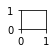

In [ ]:
#show all the images of the recommended songs
for i in range(len(song_image)):
    plt.subplot(len(song_image)//2,(len(song_image)//2)+1,i+1)
    image=io.imread(song_image[i])
    plt.imshow(image)
    plt.xlabel((song_name[i],":",artist_name[i]),size=10)
